In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

print(torch.cuda.get_device_name(0))


Using GPU
NVIDIA GeForce RTX 3060 Laptop GPU


In [25]:
week_1 = "../data/traffic/OpenStack/CIDDS-001-internal-week1.csv"
week_2 = "../data/traffic/OpenStack/CIDDS-001-internal-week2.csv"

In [26]:
week_1 = pd.read_csv(week_1)
week_2 = pd.read_csv(week_2)

C:\Users\cupca\AppData\Local\Temp\ipykernel_22056\734835057.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  week_1 = pd.read_csv(week_1)
C:\Users\cupca\AppData\Local\Temp\ipykernel_22056\734835057.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  week_2 = pd.read_csv(week_2)


In [27]:
# Rename columns
week_1 = week_1.rename(str.lower, axis='columns')
week_1 = week_1.rename(str.strip, axis='columns')
week_1.rename(columns={
            'date first seen': 'date_first_seen', 
            'src ip addr': 'src_ip_addr',
            'src pt': 'src_pt',
            'dst ip addr': 'dst_ip_addr',
            'dst pt': 'dst_pt',
            'attacktype': 'attack_type',
            'attackid': 'attack_id',
            'attackdescription': 'attack_description',
            'class': 'label'
        }, inplace=True)

week_2 = week_2.rename(str.lower, axis='columns')
week_2 = week_2.rename(str.strip, axis='columns')
week_2.rename(columns={
            'date first seen': 'date_first_seen', 
            'src ip addr': 'src_ip_addr',
            'src pt': 'src_pt',
            'dst ip addr': 'dst_ip_addr',
            'dst pt': 'dst_pt',
            'attacktype': 'attack_type',
            'attackid': 'attack_id',
            'attackdescription': 'attack_description',
            'class': 'label'
        }, inplace=True)

In [28]:
week_1.shape, week_2.shape

((8451520, 16), (10310733, 16))

In [29]:
def remove_million(val):
    """
    Removes the 'M' or 'K' suffix from a string and converts it to a numeric value.

    Args:
        val (str or int): The value to be processed. If it is a string, it should contain a suffix 'M' or 'K'.

    Returns:
        str or int: The processed value. If the input is a string, it is converted to an integer.

    Example:
        >>> remove_million('1.5 M')
        1500000
        >>> remove_million('2.3 K')
        2300
        >>> remove_million(100)
        100
    """
    if type(val) is str:                
        val = val.strip()
        if ' M' in val:                    
            val = val.replace('.', '')
            val = val.replace(' M', '00000')  
        if ' K' in val:                    
            val = val.replace('.', '')
            val = val.replace(' K', '000')                
        return val
    elif type(val) is int:
        return val

In [30]:
def hex_to_tcp_flags(hex_value):
    """
    Converts a hexadecimal value to TCP flags.

    Args:
    hex_value (str): The hexadecimal value to convert.

    Returns:
    str: The TCP flags represented as a string.

    Example:
    >>> hex_to_tcp_flags('0x52')
    '.E.A..S.'
    """
    binary_value = bin(int(hex_value, 16))[2:].zfill(8)
    flags = ['C', 'E', 'U', 'A', 'P', 'R', 'S', 'F']
    tcp_flags = ''.join([flags[i] if bit == '1' else '.' for i, bit in enumerate(binary_value)])
    return tcp_flags

In [31]:
data_dfs = [week_1, week_2]
for df in data_dfs:
    # Remove million suffix from 'bytes' column
    df['bytes'] = df['bytes'].apply(remove_million)
    df['bytes'] = pd.to_numeric(df['bytes'], errors='raise', downcast='float')
    
    # Remove NA and INF values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("N/A rows after preproc", df.isna().any(axis=1).sum())
    df.dropna(inplace=True)
    
    # Convert hexadecimal TCP flags to custom format
    df["flags"] = df["flags"].apply(lambda x:hex_to_tcp_flags(x) if '0x' in x else x)
    df['flags'] = df['flags'].apply(lambda x: '.' * (8 - len(str(x))) + str(x))

    # One-hot encode TCP flags
    df['flags'] = df['flags'].str.strip()
    data_df = df['flags'].apply(func=lambda flag_str: [0 if c == '.' else 1 for c in flag_str]).to_list()
    columns_df = ['tcp_con','tcp_ech','tcp_urg', 'tcp_ack', 'tcp_psh', 'tcp_rst', 'tcp_syn', 'tcp_fin']
    ohe_flag_data = pd.DataFrame(data=data_df,columns=columns_df,dtype=int)
    flags_idx = df.columns.get_loc('flags')
    for i, c in enumerate(ohe_flag_data.columns):
        df.insert(loc=flags_idx+i, column=c, value=ohe_flag_data[c])

    # Preprocess other columns
    df["proto"] = df["proto"].str.strip()
    df['attack_type'] = df['attack_type'].replace({'---': 'benign'})
    df['attack_id'] = df['attack_id'].replace({'---': 0})
    df['attack_id'] = df['attack_id'].astype(np.int32)
    df['tos'] = df['tos'].astype(np.int32)
    df.reset_index(drop=True, inplace=True)

N/A rows after preproc 0
N/A rows after preproc 0


In [32]:
week_1.date_first_seen.min(), week_1.date_first_seen.max(), week_2.date_first_seen.min(), week_2.date_first_seen.max()

('2017-03-15 00:01:16.551',
 '2017-03-21 23:59:58.299',
 '2017-03-22 00:00:00.070',
 '2017-03-28 23:58:21.138')

In [33]:
week_1['date_first_seen'] = pd.to_datetime(week_1['date_first_seen'], format='%Y-%m-%d %H:%M:%S.%f')
week_2['date_first_seen'] = pd.to_datetime(week_2['date_first_seen'], format='%Y-%m-%d %H:%M:%S.%f')

In [34]:
#from week 1 select date range 2:18:05 p.m., 17 March 2017 and 5:42:17 p.m., 20 March 2017
week_1 = week_1[(week_1['date_first_seen'] >= '2017-03-17 14:18:05') & (week_1['date_first_seen'] <= '2017-03-20 17:42:17')]

In [35]:
data_dfs = [week_1, week_2]

In [36]:
#check if any column has only one unique value
for df in data_dfs:
    for col in df.columns:
        if len(df[col].unique()) == 1:
            print(col, df.shape)

flows (2535985, 24)
tcp_con (2535985, 24)
tcp_ech (2535985, 24)
tcp_urg (2535985, 24)
flows (10310733, 24)
tcp_con (10310733, 24)
tcp_ech (10310733, 24)
tcp_urg (10310733, 24)


In [37]:
for df in data_dfs:
    df.drop(columns=['src_ip_addr', 'dst_ip_addr', 'tcp_urg', 'tcp_ech', 'tcp_con', 'flows'], inplace=True)

In [38]:
for df in data_dfs:
    df.drop(columns=['flags', 'attack_id', 'attack_description', 'date_first_seen'], inplace=True)

In [39]:
week_1.reset_index(drop=True, inplace=True)

In [40]:
#split the week_1 data into train and test to make sure that the test data has all the attack types but also not to shuffle the indexes
attack_types = week_1['attack_type'].unique()
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for at in attack_types:
    at_df = week_1[week_1['attack_type'] == at]
    at_train_df = at_df.iloc[:int(0.8 * at_df.shape[0])]
    at_test_df = at_df.iloc[int(0.8 * at_df.shape[0]):]
    #at_train_df, at_test_df = train_test_split(at_df, test_size=0.2, shuffle=False)
    train_df = pd.concat([train_df, at_train_df])
    test_df = pd.concat([test_df, at_test_df])

In [41]:
#print all unique values of the categorical columns
cat_cols = ['proto', 'tos', 'attack_type', 'label', 'tcp_ack', 'tcp_fin', 'tcp_psh', 'tcp_rst', 'tcp_syn']
for col in cat_cols:
    print(col, train_df[col].unique(), "train_df")
    print(col, test_df[col].unique(), "test_df")


proto ['TCP' 'UDP' 'ICMP' 'IGMP'] train_df
proto ['TCP' 'UDP' 'ICMP' 'IGMP'] test_df
tos [  0  32 192  16] train_df
tos [  0  32 192  16] test_df
attack_type ['dos' 'benign' 'portScan' 'pingScan' 'bruteForce'] train_df
attack_type ['dos' 'benign' 'portScan' 'pingScan' 'bruteForce'] test_df
label ['attacker' 'victim' 'normal'] train_df
label ['victim' 'attacker' 'normal'] test_df
tcp_ack [1 0] train_df
tcp_ack [1 0] test_df
tcp_fin [1 0] train_df
tcp_fin [1 0] test_df
tcp_psh [1 0] train_df
tcp_psh [0 1] test_df
tcp_rst [0 1] train_df
tcp_rst [0 1] test_df
tcp_syn [1 0] train_df
tcp_syn [1 0] test_df


In [42]:
# set float format
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [43]:
datasets = [train_df, test_df]

In [44]:
for df in datasets:
    #normalize values
    df["src_pt"] = df["src_pt"]/df["src_pt"].max()
    df["dst_pt"] = df["dst_pt"]/df["dst_pt"].max()
    columns_df = ['duration', 'bytes', 'packets']
    for c in columns_df:
        if c == "duration":
            df[c] = np.log(df[c]+1)
        else:
            df[c] = np.log(df[c])
        df[c] = (df[c]-df[c].min())/(df[c].max()-df[c].min())

In [45]:
for df in datasets:
    # remove duplicated rows
    dupli = df.duplicated().sum()
    if dupli > 0:
        print(dupli, "fully duplicate rows")
        df.drop_duplicates(inplace=True)
        df.reset_index(drop=True, inplace=True)

864453 fully duplicate rows
179909 fully duplicate rows


## Check RF stuff

In [24]:
import sys
sys.path.append('..')



In [25]:
#train a basic rf classifier on the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder


In [26]:
le_dict = {"attack_type": "le_attack_type", "label": "le_label", "proto": "le_proto", "tos": "le_tos"}
for c in le_dict.keys():
    le_dict[c] = LabelEncoder()
    train_df[c] = le_dict[c].fit_transform(train_df[c])
    train_df[c] = train_df[c].astype("int64")
    test_df[c] = le_dict[c].fit_transform(test_df[c])
    test_df[c] = test_df[c].astype("int64")

In [37]:
# train a random forest classifier on target attack_type
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_df.drop(columns=['attack_type', 'label', 'src_pt', 'dst_pt']), train_df['attack_type'])


RandomForestClassifier(random_state=42)

In [39]:
predict = rf.predict(test_df.drop(columns=['attack_type', 'label', 'src_pt', 'dst_pt']))

In [29]:
from sklearn import metrics

In [40]:
pred = rf.predict_proba(test_df.drop(columns=['attack_type', 'label', 'src_pt', 'dst_pt']))
acc_weighted = metrics.balanced_accuracy_score(test_df['attack_type'],predict)*100
auc_weighted = metrics.roc_auc_score(test_df['attack_type'], pred,average="weighted",multi_class="ovo")
f1_score_weighted = metrics.precision_recall_fscore_support(test_df['attack_type'], predict,average="weighted")

In [7]:
a = a.split("\n")
a = [x.split() for x in a]
a[0] = ['attack_type', 'precision', 'recall', 'f1-score', 'support']
a = [x for x in a if x]
a = {x[0]:x[1:] for x in a}

#if the length of the values is less than 4, add empty strings to the left to make it 4
for k,v in a.items():
    if len(v) < 4:
        a[k] = ['']*(4-len(v)) + v
        
#if length of the values is more than 4, remove the first value
for k,v in a.items():
    if len(v) > 4:
        a[k] = v[1:]
        
a = pd.DataFrame(a, columns=a.keys()).transpose()
#convert index to a column
a.reset_index(inplace=True)
a.rename(columns={"index":"attack_type"}, inplace=True)
a.columns = a.iloc[0].str.strip()
#remove first row of a
a = a[1:]
a["Model"] = "mlp"

In [170]:
# get the fale positive rate and true positive rate and precision, recall, everything macro averaged
cr = classification_report(test_df['attack_type'], predict, target_names=le_dict['attack_type'].classes_, output_dict=True)

## Back to Transform

In [77]:
#split the week_1 data into train and test to make sure that the test data has all the attack types but also not to shuffle the indexes
attack_types = week_2['attack_type'].unique()
hpo_train_df = pd.DataFrame()
hpo_test_df = pd.DataFrame()
for at in attack_types:
    hpo_at_df = week_2[week_2['attack_type'] == at]
    hpo_at_train_df = hpo_at_df.iloc[:int(0.95 * hpo_at_df.shape[0])]
    hpo_at_test_df = hpo_at_df.iloc[int(0.95 * hpo_at_df.shape[0]):]
    hpo_train_df = pd.concat([hpo_train_df, hpo_at_train_df])
    hpo_test_df = pd.concat([hpo_test_df, hpo_at_test_df])

In [78]:
# remove duplicates from hpo datasets
hpo_datasets = [hpo_train_df, hpo_test_df]
for df in hpo_datasets:
    #normalize values
    df["src_pt"] = df["src_pt"]/df["src_pt"].max()
    df["dst_pt"] = df["dst_pt"]/df["dst_pt"].max()
    columns_df = ['duration', 'bytes', 'packets']
    for c in columns_df:
        if c == "duration":
            df[c] = np.log(df[c]+1)
        else:
            df[c] = np.log(df[c])
        df[c] = (df[c]-df[c].min())/(df[c].max()-df[c].min())

In [79]:

for df in hpo_datasets:
    # remove duplicated rows
    dupli = df.duplicated().sum()
    if dupli > 0:
        print(dupli, "fully duplicate rows")
        df.drop_duplicates(inplace=True)
        df.reset_index(drop=True, inplace=True)

4792072 fully duplicate rows
195489 fully duplicate rows


In [80]:
train_df.shape, test_df.shape, hpo_train_df.shape, hpo_test_df.shape

((1164332, 14), (327291, 14), (5003122, 14), (320050, 14))

In [106]:
320050*0.00002

6.401000000000001

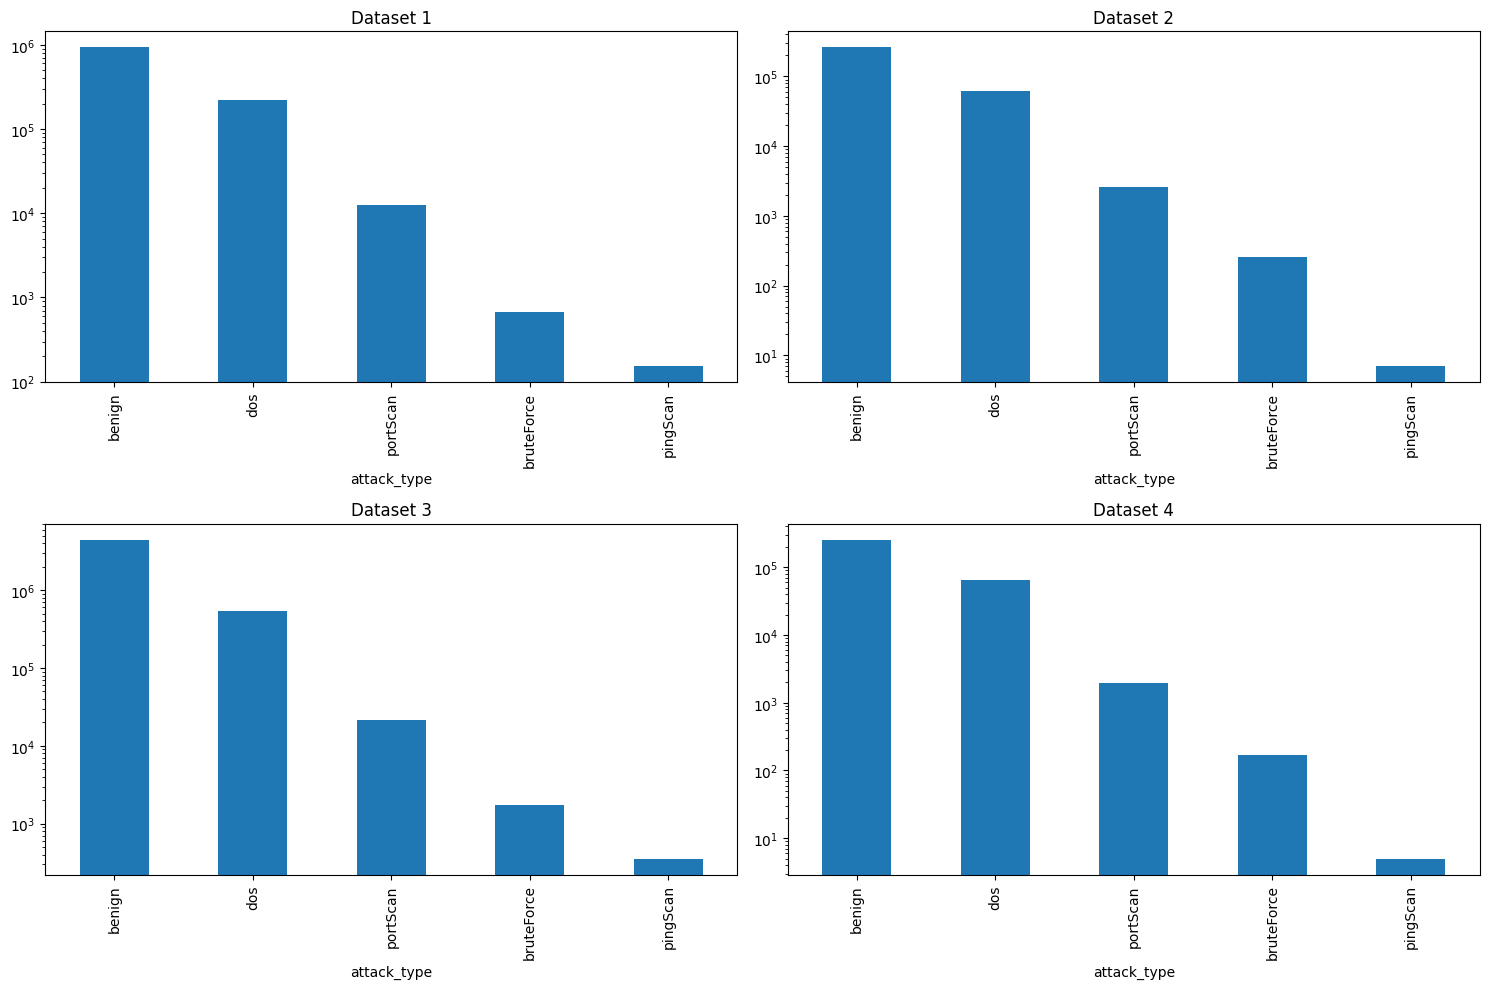

In [87]:
#plot the attack_type distribution in all 4 datasets
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, df in enumerate([train_df, test_df, hpo_train_df, hpo_test_df]):
    df['attack_type'].value_counts().plot(kind='bar', ax=axs[i], logy=True)
    axs[i].set_title(f"Dataset {i+1}")
plt.tight_layout()
plt.show()


In [92]:
# compare unique values of the categorical columns in the train and test datasets and hpo datasets
cat_cols = ['proto', 'tos', 'attack_type', 'label', 'tcp_ack', 'tcp_fin', 'tcp_psh', 'tcp_rst', 'tcp_syn']
for col in cat_cols:
    print(col, train_df[col].unique(), "train_df")
    print(col, test_df[col].unique(), "test_df")
    print(col, hpo_train_df[col].unique(), "hpo_train_df")
    print(col, hpo_test_df[col].unique(), "hpo_test_df")

proto ['TCP' 'UDP' 'ICMP' 'IGMP'] train_df
proto ['TCP' 'UDP' 'ICMP' 'IGMP'] test_df
proto ['TCP' 'UDP' 'IGMP' 'ICMP'] hpo_train_df
proto ['TCP' 'UDP' 'ICMP' 'IGMP'] hpo_test_df
tos [  0  32 192  16] train_df
tos [  0  32 192  16] test_df
tos [  0  32 192  16] hpo_train_df
tos [ 32   0 192  16] hpo_test_df
attack_type ['dos' 'benign' 'portScan' 'pingScan' 'bruteForce'] train_df
attack_type ['dos' 'benign' 'portScan' 'pingScan' 'bruteForce'] test_df
attack_type ['benign' 'portScan' 'dos' 'pingScan' 'bruteForce'] hpo_train_df
attack_type ['benign' 'portScan' 'dos' 'pingScan' 'bruteForce'] hpo_test_df
label ['attacker' 'victim' 'normal'] train_df
label ['victim' 'attacker' 'normal'] test_df
label ['normal' 'attacker' 'victim'] hpo_train_df
label ['normal' 'victim' 'attacker'] hpo_test_df
tcp_ack [1 0] train_df
tcp_ack [1 0] test_df
tcp_ack [1 0] hpo_train_df
tcp_ack [1 0] hpo_test_df
tcp_fin [1 0] train_df
tcp_fin [1 0] test_df
tcp_fin [0 1] hpo_train_df
tcp_fin [0 1] hpo_test_df
tcp_psh 

In [93]:
hpo_test_df.to_csv("../thesisgan/input/new_hpo_data.csv", index=False)
train_df.to_csv("../thesisgan/input/new_train_data.csv", index=False)
test_df.to_csv("../thesisgan/input/new_test_data.csv", index=False)

In [96]:
train_df

,duration,proto,src_pt,dst_pt,packets,bytes,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,label,attack_type
0,0.00092,TCP,0.52252,0.00122,0.14693,0.15701,1,1,0,1,1,0,attacker,dos
1,0.00037,TCP,0.52254,0.00122,0.13198,0.14910,1,1,0,1,1,0,attacker,dos
2,0.00074,TCP,0.00122,0.52257,0.09009,0.09741,1,0,0,1,1,0,victim,dos
3,0.00165,TCP,0.52277,0.00122,0.14693,0.15701,1,1,0,1,1,0,attacker,dos
4,0.00037,TCP,0.00122,0.52274,0.11368,0.11444,1,0,0,1,1,0,victim,dos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164327,0.01232,TCP,0.00034,0.78103,0.18882,0.23723,1,1,0,1,0,0,victim,bruteForce
1164328,0.02190,TCP,0.78103,0.00034,0.20377,0.26380,1,1,0,1,0,0,attacker,bruteForce
1164329,0.00165,TCP,0.00034,0.78103,0.13198,0.14689,1,1,0,0,1,0,victim,bruteForce
1164330,0.00147,TCP,0.78103,0.00034,0.13198,0.16391,1,1,0,0,1,0,attacker,bruteForce
